In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,Lambda
from keras.layers import MaxPooling2D,UpSampling2D,Concatenate,Conv2DTranspose
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.models import load_model
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.callbacks import LearningRateScheduler,Callback
from keras.optimizers import RMSprop
import cv2
from math import *
from keras.applications.vgg16 import VGG16 
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import h5py
from keras.utils import to_categorical
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from keras.preprocessing.image import ImageDataGenerator
from skimage import measure
from skimage import img_as_float32
from imutils import contours
import imutils
import scipy.misc as sm
from PIL import Image
from timeit import default_timer as timer

from numba import *
import os
import cv2
from numba import *

os.environ['NUMBAPRO_NVVM']=r'/usr/local/cuda-9.0/nvvm/lib64/libnvvm.so'

os.environ['NUMBAPRO_LIBDEVICE']=r'/usr/local/cuda-9.0/nvvm/libdevice/'

%matplotlib inline

Using TensorFlow backend.


In [3]:
odmodel1 = load_model('aug_inverter_on_all_imagesx5.h5')
odmodel2 = load_model('aug_inverter_on_all_imagesx5.h5')

In [4]:
im_p = "Images_for_FCRN/Test/2.JPG"

In [5]:

#@guvectorize(['np.array(..., dtype=np.float64),float32[:,:](float64[:,:,:],uint8[:,:,:])'],"(m,n),(n,p)->(m,p)",target='cuda')
@jit(["float32(float32,float32)"])
def predictor(full_image_pred,full_image):

    image = full_image_pred
    image[image<190] = 0
    
    cx_cord = []

    blurred = cv2.GaussianBlur(image, (11, 11), 0)
    thresh = cv2.threshold(blurred,190, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)

    labels = measure.label(thresh, neighbors=8, background=0)
    mask = np.zeros(thresh.shape, dtype="uint8")

    for label in np.unique(labels):
        if label == 0:
            continue


        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)

        if numPixels > 150:
            mask = cv2.add(mask, labelMask)


    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    if cnts:
        cnts = contours.sort_contours(cnts)[0]
        
    image = full_image
    
    for (i, c) in enumerate(cnts):
        (x, y, w, h) = cv2.boundingRect(c)
        ((cX, cY), radius) = cv2.minEnclosingCircle(c)
        
        cx_cord.append(cX)

        rect = cv2.fitEllipse(c)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        #cv2.drawContours(image,[box],0,(255,255,0),2)
        cv2.drawContours(image,[box],0,(255/255,255/255,0),2)

    plt.imshow(image,vmin = 0, vmax = 255)
    print("Total cars predicted = ", len(cx_cord))
    
    return image

In [6]:
full_image = cv2.imread(im_p)
full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)
full_image1 = full_image
full_image2 = full_image

(3744, 5616, 3)


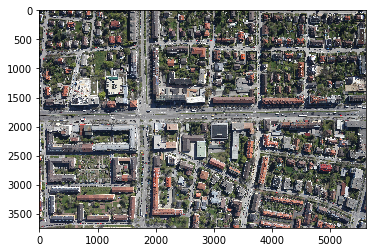

In [7]:
plt.imshow(full_image,vmin = 0,vmax = 255)
print(full_image.shape)

In [8]:
p = full_image.shape[1]
q = full_image.shape[0]
if p>224:
    new_x = (ceil(p/208)-1)*208 + 224
else:
    new_x = 224
if q>224:
    new_y = (ceil(q/208)-1)*208 + 224
else:
    new_y = 224

In [9]:
old_im = Image.open(im_p)
old_size = old_im.size

new_size = (new_x,new_y)
new_im = Image.new("RGB", new_size)   ## luckily, this is already black!
new_im.paste(old_im, ((int)((new_size[0]-old_size[0])/2), (int)((new_size[1]-old_size[1])/2)))
full_image = np.asarray(new_im,dtype = np.float32)
full_image1 = full_image2 = full_image
#full_image = full_image/255

(3760, 5632, 3)


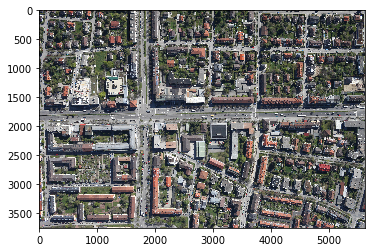

In [10]:
plt.imshow(full_image/255,vmin = 0,vmax = 255)
print(full_image.shape)

In [11]:
def cropper1(x_img,x0,y0):
    x0_end = x0 + 224
    y0_end = y0 + 224
    cropped_img = x_img[x0:x0_end,y0:y0_end]
    #cropped_img = np.asarray(cropped_img,dtype = np.float32)
    return cropped_img

def cropper2(x_img,x0,y0):
    x0_end = x0 + 224
    y0_end = y0 + 224
    cropped_img = x_img[x0:x0_end,y0:y0_end]
    #cropped_img = np.asarray(cropped_img,dtype = np.float32)
    return cropped_img

In [12]:
print(full_image.shape)
full_image_p = np.zeros((new_y,new_x),dtype = np.float32)
full_image_p1 = np.zeros((new_y,new_x),dtype = np.float32)
full_image_p2 = np.zeros((new_y,new_x),dtype = np.float32)
print(full_image_p.shape)

(3760, 5632, 3)
(3760, 5632)


In [24]:
def pred1(img_part):
    print("You are in pred1")
    return odmodel1.predict(img_part)
    print("You are out of pred1")
    
def pred2(img_part):
    print("You are in pred2")
    return odmodel2.predict(img_part)
    print("You are out of pred2")


In [14]:
@jit(["void(float32,float32,int64,int64)"])
def place1(prediction,full_image_p,y,x):
    #prediction = np.asarray(prediction)
    #full_image_p = np.asarray(full_image_p)
    for i in range(224):
        for j in range(224):
            full_image_p[y + i][x + j] = max(full_image_p[y + i][x + j],prediction[0][i][j])
            
@jit(["void(float32,float32,int64,int64)"])
def place2(prediction,full_image_p,y,x):
    #prediction = np.asarray(prediction)
    #full_image_p = np.asarray(full_image_p)
    for i in range(224):
        for j in range(224):
            full_image_p[y + i][x + j] = max(full_image_p[y + i][x + j],prediction[0][i][j])

In [25]:
#@vectorize(["int64(int64,int64,float32,float32)"],target = 'cuda')
def func1(new_x1,new_y1,full_image1,full_image_p1):
    print("Func1 starting...")
    dur_predict1 = 0
    dur_place1 = 0
    dur_crop1 = 0
    start = timer()
    for x in range(int(floor(new_x1/208)/2)):
        for y in range(floor(new_y1/208)):
            start3 = timer()
            print("cropper1 starting...")

            img_part1 = cropper1(full_image1,y*208,x*208) # overlap = 16 therefore (224 - 16 = 208)
            dur_crop1 = dur_crop1 + timer() - start3
            img_part1 = np.asarray(img_part1)
            img_part1 = img_part1.reshape((1,224,224,3))
            img_part1 = 255 - img_part1
            start1 = timer()
            print("Pred1 starting...")
            prediction1 = pred1(img_part1)
            dur_predict1 = dur_predict1 + timer() - start1
            prediction1 = np.asarray(prediction1,dtype = np.float32)
            #print(prediction.shape)
            print(x," ",y, " 1")
            prediction1 = prediction1.reshape((1,224,224))
            start1 = timer()
            start2 = timer()
            place1(prediction1,full_image_p1,y*208,x*208)
            dur_place1 = dur_place1 + timer()- start2
            #print(timer()-start1)
            #full_image_p[y*224:(y+1)*224,x*224:(x+1)*224] = prediction[0]
            #full_image_p[y*208:y*208 + 224,x*208:x*208 + 224] = prediction[0]
        
    duration1 = timer() - start
    print(duration1)
    print(dur_crop1)
    print(dur_predict1)
    print(dur_place1)

In [26]:
def func2(new_x2,new_y2,full_image2,full_image_p2):
    print("Func2 starting...")
    dur_predict2 = 0
    dur_place2 = 0
    dur_crop2 = 0
    start = timer()
    for x in range(int(floor(new_x2/208)/2),floor(new_x2/208)):
        for y in range(floor(new_y2/208)):
            start3 = timer()
            print("cropper2 starting...")
            img_part2 = cropper2(full_image2,y*208,x*208) # overlap = 16 therefore (224 - 16 = 208)
            dur_crop2 = dur_crop2 + timer() - start3
            img_part2 = np.asarray(img_part2)
            img_part2 = img_part2.reshape((1,224,224,3))
            img_part2 = 255 - img_part2
            start1 = timer()
            print("Pred2 starting...")
            prediction2 = pred2(img_part2)
            dur_predict2 = dur_predict2 + timer() - start1
            prediction2 = np.asarray(prediction2,dtype = np.float32)
            #print(prediction.shape)
            print(x," ",y," 2")
            prediction2 = prediction2.reshape((1,224,224))
            #start1 = timer()
            start2 = timer()
            place2(prediction2,full_image_p2,y*208,x*208)
            dur_place2 = dur_place2 + timer()- start2
            #print(timer()-start1)
            #full_image_p[y*224:(y+1)*224,x*224:(x+1)*224] = prediction[0]
            #full_image_p[y*208:y*208 + 224,x*208:x*208 + 224] = prediction[0]

    duration2 = timer() - start
    print(duration2)
    print(dur_crop2)
    print(dur_predict2)
    print(dur_place2)
    #prediction1 = odmodel.predict(img_part1)
    #return odmodel.predict(full_image2)

In [27]:
from multiprocessing import Process
print(new_x)
print(new_y)
def bablu():
    start = timer()
    p1 = Process(target = func1,args=(new_x,new_y,full_image,full_image_p,))
    p1.start()
    p2 = Process(target = func2,args=(new_x,new_y,full_image,full_image_p,))
    p2.start()
    end = timer()
    print("finished")
    print(end - start)

5632
3760


In [28]:
bablu()

finished
0.11777819902636111
Func1 starting...
cropper1 starting...
Pred1 starting...
You are in pred1
Func2 starting...
cropper2 starting...
Pred2 starting...
You are in pred2
